In [1]:
import pandas as pd
import numpy as np
import pandas_profiling # https://github.com/pandas-profiling/pandas-profiling
import seaborn as sns
import matplotlib.pyplot as plt
import qgrid
from scipy import stats
from scipy.stats import skew, norm
from scipy.stats.stats import pearsonr
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_squared_log_error

np.random.seed(12345)
sns.set_style("dark")
# plt.rcParams['figure.figsize'] = 12, 8

## Load data

In [2]:
train = pd.read_csv('../data/house-prices/train.csv')
test = pd.read_csv('../data/house-prices/test.csv')
y_train = train['SalePrice']
test_ids = test['Id']
# qgrid_widget = qgrid.show_grid(train, show_toolbar=True)
# qgrid_widget

## Explore the data and get insights

### Get statistics by every column

In [3]:
# profile = pandas_profiling.ProfileReport(train, title='Pandas Profiling Report')
# profile.to_file(output_file="../data/house-prices/train_profiling_report.html")

### Target value distribution

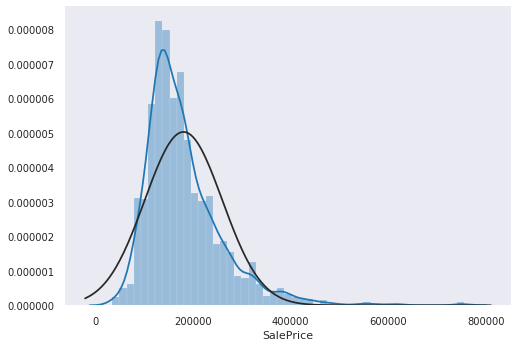

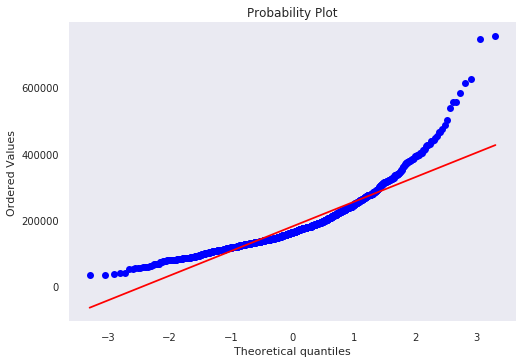

skewness: 1.8828757597682129
kurtosis: 6.536281860064529


In [4]:
sns.distplot(y_train, fit=norm)
# QQ plot
fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()
print(f"skewness: {y_train.skew()}")
print(f"kurtosis: {y_train.kurt()}")

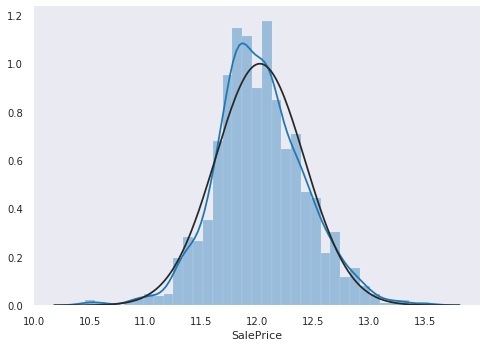

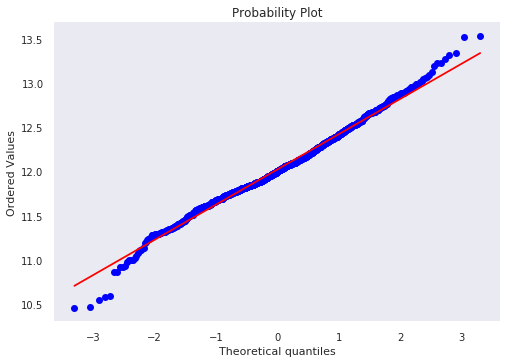

skewness: 0.12134661989685333
kurtosis: 0.809519155707878


In [5]:
# transform the target
salePrice = np.log1p(y_train)
sns.distplot(salePrice, fit=norm)
# QQ plot
fig = plt.figure()
res = stats.probplot(salePrice, plot=plt)
plt.show()
print(f"skewness: {salePrice.skew()}")
print(f"kurtosis: {salePrice.kurt()}")

### Select impactful predictors 

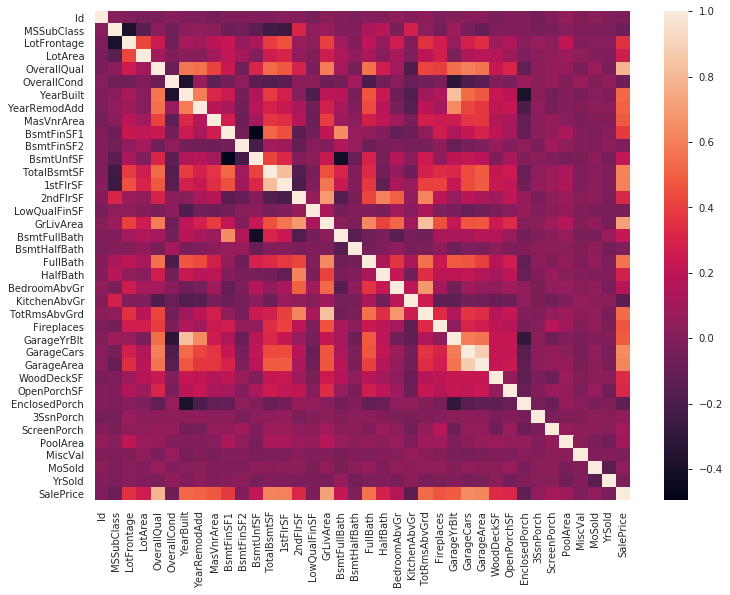

In [6]:
corr_matrix = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_matrix)
plt.show()

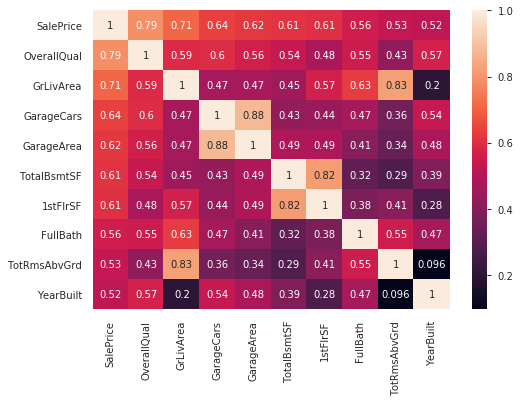

In [7]:
corr_columns = corr_matrix.nlargest(10, 'SalePrice')['SalePrice'].index
corr_coefficients = np.corrcoef(train[corr_columns].values.T)
hm = sns.heatmap(corr_coefficients, annot=True, annot_kws={'size': 10}, xticklabels=corr_columns.values, yticklabels=corr_columns.values)
plt.show()

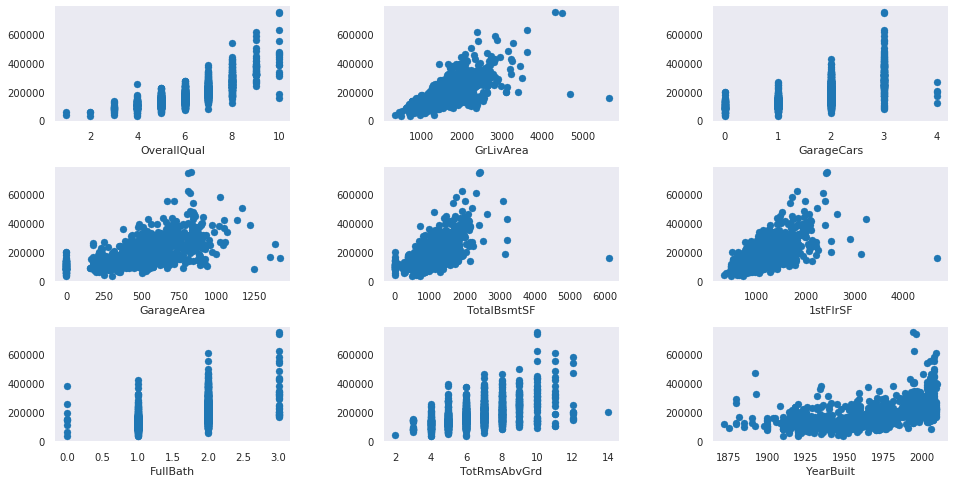

In [8]:
corr_columns = [x for x in corr_columns if x != 'SalePrice']
fig = plt.figure(figsize=(16, 8))
for i, column in enumerate(corr_columns):
    plt.subplot(3, 3, i+1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.scatter(train[corr_columns[i]], train['SalePrice'])
    plt.xlabel(column)

### Preprocess datasets

Numeric features that are highly correlated with the SalePrice:

- OverallQual: Rates the overall material and finish of the house
- GrLivArea: Above grade (ground) living area square feet
- GarageCars: Size of garage in car capacity
- GarageArea: Size of garage in square feet
- TotalBsmtSF: Total square feet of basement area
- 1stFlrSF: First Floor square feet
- FullBath: Full bathrooms above grade       	
- TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
- YearBuilt: Original construction date

Data preprocessing would include:
* Merge train and test datasets
* Fill missing values
* Encode categorical data
* Standardization (numeric values are rescaled in order to have mean=0 and standard deviation=1)

In [9]:
# delete outliers
# train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

# merge train and test datasets
train.drop(['Id', 'SalePrice'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)
all_data = pd.concat((train, test), axis=0)
print("all_data size: {} ".format(all_data.shape))
column_names = list(all_data.columns)
# find columns with N/A
columns_with_na = []
for column in all_data:
    if sum(all_data[column].isnull()) > 0:
        columns_with_na.append(column)
print(f"Columns with N/A values ({len(columns_with_na)} of {all_data.shape[1]})")
# fill N/A with a dict where a column mapped to a most common value
fillna_dict = dict((col, all_data[col].value_counts().idxmax()) for col in columns_with_na)
all_data.fillna(value=fillna_dict, inplace=True)
# encode all categorical features
all_data = all_data.astype(str)
oe = OrdinalEncoder()
oe.fit(all_data)
all_data = oe.transform(all_data)
# scale all_data
scaler = StandardScaler()
all_data = scaler.fit_transform(all_data)
# scale y_train
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(pd.DataFrame(y_train))


all_data size: (2919, 79) 
Columns with N/A values (34 of 79)


Select features

In [10]:
n_train = train.shape[0]
X_train = pd.DataFrame(all_data[:n_train])
X_test = pd.DataFrame(all_data[n_train:])
# select features
amount = 10
fs = SelectKBest(score_func=f_regression, k=amount)
fs.fit(X_train, y_train.ravel())
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)


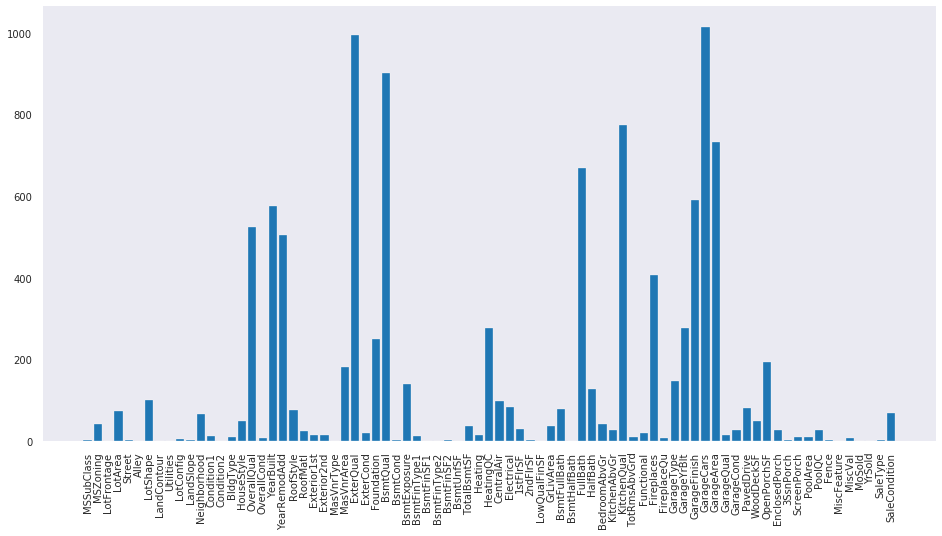

In [11]:
# visualize the importance of features
fig = plt.figure(figsize=(16, 8))
plt.bar(column_names, fs.scores_)
plt.xticks(rotation=90)
plt.show()
# for i in range(len(fs.scores_)):
# print(f'Feature {i}: {fs.scores_[i]}')

## Build a model


In [12]:
model = LinearRegression()
scoring = 'neg_mean_squared_error'
kfold = KFold(n_splits=10, shuffle=True, random_state=7)
crossval_results = cross_val_score(model, X_train_fs, y_train, cv=kfold, scoring=scoring)
print(f"LinearRegression: mean={crossval_results.mean()}, std={crossval_results.std()}")

LinearRegression: mean=-0.3370033214144179, std=0.09215923913034592


In [13]:
test_size = 100
# TODO: get more info about indexing in pandas/numpy
my_X_train = X_train_fs[:X_train_fs.shape[0]-test_size, :]
my_X_test = X_train_fs[X_train_fs.shape[0]-test_size:, :]
my_y_train = y_train[:y_train.shape[0]-test_size]
my_y_test = y_train[y_train.shape[0]-test_size:]

my_model = LinearRegression()
my_scoring = 'neg_mean_squared_error'
kfold = KFold(n_splits=10, shuffle=True, random_state=7)
my_crossval_results = cross_val_score(my_model, my_X_train, my_y_train, cv=kfold, scoring=my_scoring)
print(f"LinearRegression: mean={my_crossval_results.mean()}, std={my_crossval_results.std()}")

my_model.fit(my_X_train, my_y_train)
print(f'Accuracy (R^2) of LinReg model on training set: {my_model.score(my_X_train, my_y_train)}')
print(f'Accuracy (R^2) of LinReg model on test set: {my_model.score(my_X_test, my_y_test)}')

my_y_train_pred = my_model.predict(my_X_train)
my_X_test_pred = my_model.predict(my_X_test)
# print("mean_squared_log_error on training set:", mean_squared_log_error(my_y_train, my_y_train_pred))
# print("mean_squared_log_error on test set:", mean_squared_log_error(my_y_test, my_X_test_pred))
print(f"mean_squared_error on training set:", mean_squared_error(my_y_train, my_y_train_pred))
print(f"mean_squared_error on test set:", mean_squared_error(my_y_test, my_X_test_pred))

LinearRegression: mean=-0.34995544556381103, std=0.11603455085125225
Accuracy (R^2) of LinReg model on training set: 0.6688922368822643
Accuracy (R^2) of LinReg model on test set: 0.7105375140395795
mean_squared_error on training set: 0.3352297739615274
mean_squared_error on test set: 0.2399959817856185


## Submit the prediction

In [14]:
model.fit(X_train_fs, y_train)
print("Accuracy (R^2) of LinReg model on training set:", model.score(X_train_fs, y_train))
prediction = model.predict(X_test_fs)
prediction = prediction.ravel()
prediction = y_scaler.inverse_transform(prediction)
submission = pd.DataFrame({
    "Id": test_ids,
    "SalePrice": prediction
})
submission.to_csv("../data/house-prices/house-prices-submission.csv", index=False)
submission.head()

Accuracy (R^2) of LinReg model on training set: 0.6715207216479564


,Id,SalePrice
0,1461,120419.386358
1,1462,123125.879296
2,1463,183130.625055
3,1464,190477.963223
4,1465,229164.151907
